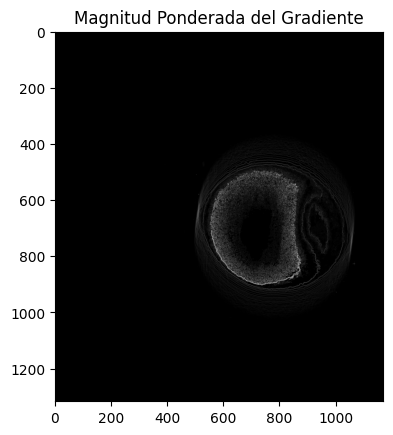

Dirección ponderada del desenfoque: 19.442368851094592 grados
Longitud estimada del desenfoque: 86.91727761952124
Estimated speed of: 8691.727761952125 pixels per second


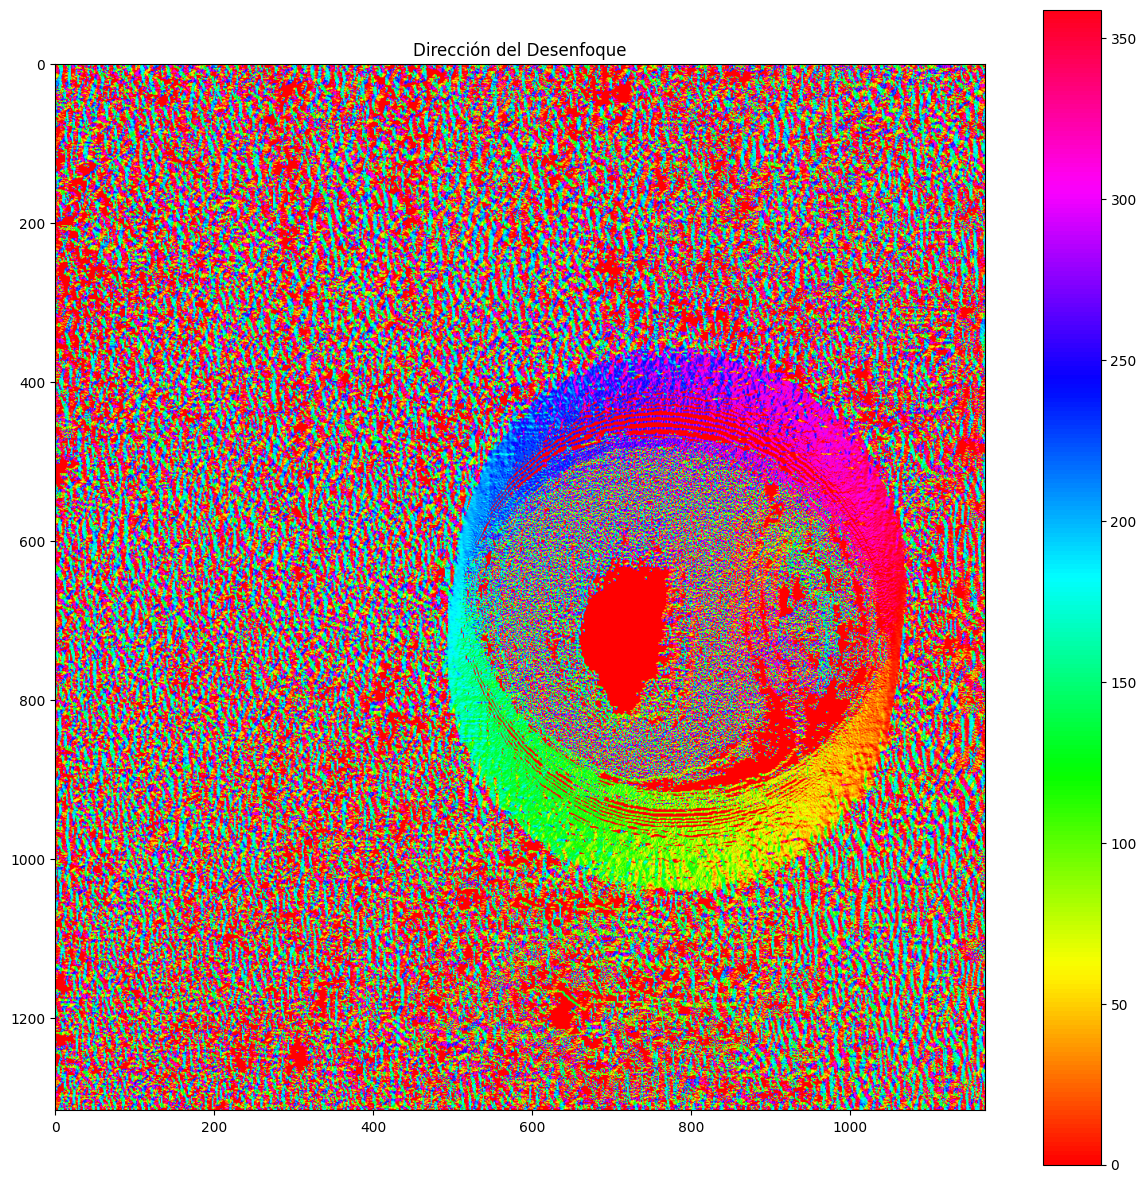

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("../assets/images/flyingball.png", cv2.IMREAD_GRAYSCALE)

alpha_map = cv2.imread('../output/alpha/flyingball_alpha.png', cv2.IMREAD_GRAYSCALE) 

alpha_map = alpha_map / 255.0

sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

magnitude = cv2.magnitude(sobel_x, sobel_y)
angle = cv2.phase(sobel_x, sobel_y, angleInDegrees=True)

weighted_magnitude = magnitude * alpha_map

plt.imshow(weighted_magnitude, cmap='gray')
plt.title('Weighted Gradient Magnitude')
plt.show()

mean_angle = np.mean(angle * alpha_map)
print(f"Weighted blur direction: {mean_angle} degrees")

blur_length = np.max(weighted_magnitude)
print(f"Estimated blur length: {blur_length}")

exposure_time = 0.01  # seconds

velocity = blur_length / exposure_time
print(f"Estimated speed of: {velocity} pixels per second")

plt.figure(figsize=(15, 15))
plt.imshow(angle, cmap='hsv')
plt.title('Blur Direction')
plt.colorbar()
plt.show()


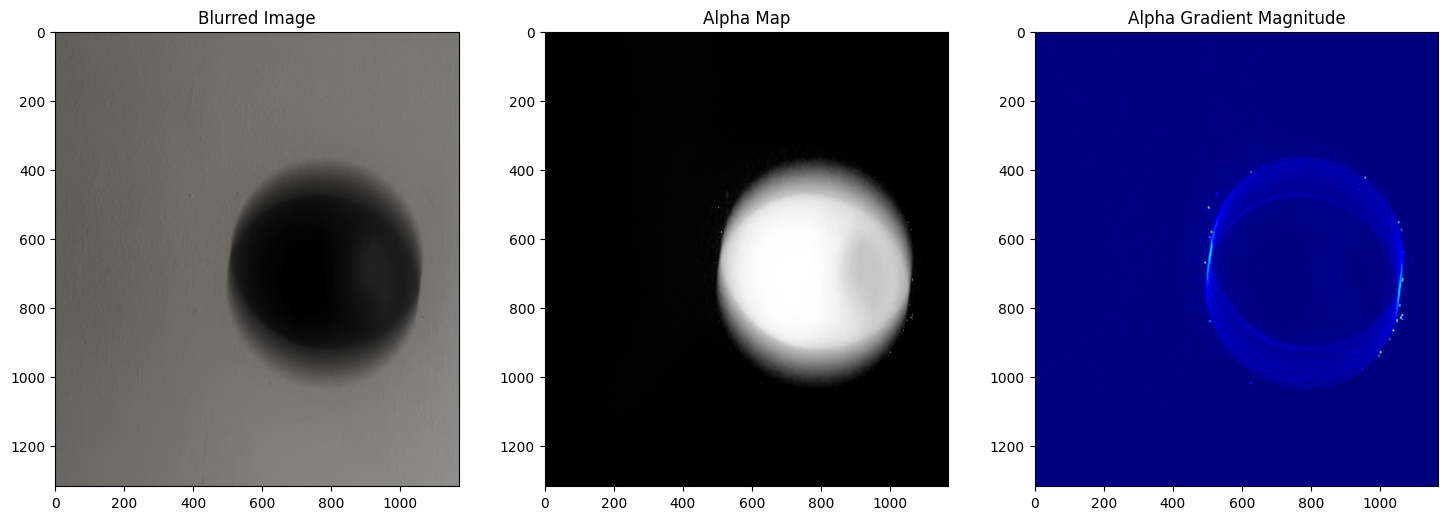

In [27]:
# Load your blurred image and alpha map (replace with your filenames)
blurred_image = cv2.imread("../assets/images/flyingball.png")
alpha = cv2.imread('../output/alpha/flyingball_alpha.png', cv2.IMREAD_GRAYSCALE) / 255.0  # Normalize to [0, 1]

# Ensure alpha is same size as blurred image (resize if needed)
alpha = cv2.resize(alpha, (blurred_image.shape[1], blurred_image.shape[0]))

# Preprocess alpha (optional: smooth to reduce noise)
alpha_smoothed = cv2.GaussianBlur(alpha, (5, 5), 0)

# 1. Detect region borders (start/end contours) from alpha gradient
grad_x = cv2.Sobel(alpha_smoothed, cv2.CV_64F, 1, 0, ksize=3)
grad_y = cv2.Sobel(alpha_smoothed, cv2.CV_64F, 0, 1, ksize=3)
grad_mag = np.sqrt(grad_x**2 + grad_y**2)

# Threshold gradient to find sharp edges (type 1a/1b borders)
_, edges = cv2.threshold(np.uint8(grad_mag * 255), 30, 255, cv2.THRESH_BINARY)

# Find contours of region borders
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 2. Extract iso-alpha contours (temporal super-resolution)
def get_iso_contours(alpha, thresholds=[0.3, 0.5, 0.7]):
    iso_contours = []
    for thresh in thresholds:
        _, binary = cv2.threshold((alpha * 255).astype(np.uint8), int(thresh * 255), 255, cv2.THRESH_BINARY)
        cnts, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        iso_contours.extend(cnts)
    return iso_contours

iso_contours = get_iso_contours(alpha_smoothed)

# 3. Combine all contours to reconstruct shape
mask = np.zeros_like(alpha_smoothed, dtype=np.uint8)
cv2.drawContours(mask, list(contours) + iso_contours, -1, 255, thickness=cv2.FILLED)

# 4. Refine mask (optional: morphological closing)
kernel = np.ones((5,5), np.uint8)
mask_refined = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# 5. Overlay reconstructed shape on blurred image
result = cv2.bitwise_and(blurred_image, blurred_image, mask=mask_refined)

# Visualize results
plt.figure(figsize=(15, 10))
plt.subplot(231), plt.imshow(cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB)), plt.title('Blurred Image')
plt.subplot(232), plt.imshow(alpha, cmap='gray'), plt.title('Alpha Map')
plt.subplot(233), plt.imshow(grad_mag, cmap='jet'), plt.title('Alpha Gradient Magnitude')
"""
plt.subplot(234), plt.imshow(edges, cmap='gray'), plt.title('Region Borders (Edges)')
plt.subplot(235), plt.imshow(mask_refined, cmap='gray'), plt.title('Reconstructed Shape Mask')
plt.subplot(236), plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB)), plt.title('Final Result Overlay')"""
plt.tight_layout()
plt.show()